In [1]:
import re
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import csv
import urllib.request, urllib.parse, urllib.error
from urllib.request import urlopen
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
%matplotlib inline

In [29]:
data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
data

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221906,ZWE,Africa,Zimbabwe,2022-10-02,257517.0,52.0,25.286,5602.0,0.0,0.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
221907,ZWE,Africa,Zimbabwe,2022-10-03,257538.0,21.0,28.000,5603.0,1.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
221908,ZWE,Africa,Zimbabwe,2022-10-04,257568.0,30.0,27.429,5603.0,0.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
221909,ZWE,Africa,Zimbabwe,2022-10-05,257568.0,0.0,22.714,5603.0,0.0,0.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [3]:
# Cleaning data
columns_empty_values = data.isnull().sum().to_dict()                                                # Getting rid of columns with a lot of empty values
col_to_delete  = [x for x in columns_empty_values.keys() if columns_empty_values[x] > 200000]

col_to_delete
data.drop(col_to_delete, inplace=True, axis=1)

In [4]:
dupl_rows = data.duplicated().to_dict()    # Checking for duplicate rows
print("True" in dupl_rows.values())

False


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221911 entries, 0 to 221910
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    221911 non-null  object 
 1   continent                                   209160 non-null  object 
 2   location                                    221911 non-null  object 
 3   date                                        221911 non-null  object 
 4   total_cases                                 212763 non-null  float64
 5   new_cases                                   212533 non-null  float64
 6   new_cases_smoothed                          211337 non-null  float64
 7   total_deaths                                193635 non-null  float64
 8   new_deaths                                  193604 non-null  float64
 9   new_deaths_smoothed                         192424 non-null  float64
 

In [6]:
data = data.fillna(0)    # Filling empty values 

In [7]:
# Convert the date column
data['date'] = pd.to_datetime(data['date'])

In [8]:
data.head(1)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,...,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511


In [9]:
sns.set(style = 'whitegrid')

# Plotting the correlation

Over all variables in the COVID datasets, some of them are more strongly connected than others. A heatmap can plot the correlation between each data column and return a color based on a positive or negative relation. Especially in a response to a new pandemic, a correlation plot can show the effectiveness of different measures such as vaccines and increased testing. 

However, the results have to be thoroughly inspected. From the following plot, one could assume that giving out boosters has a positive effect on the number of cases and therefore are harmful. In this case, we have to take into account boosters were only implemented late in the pandemic when the numbers were already high. 

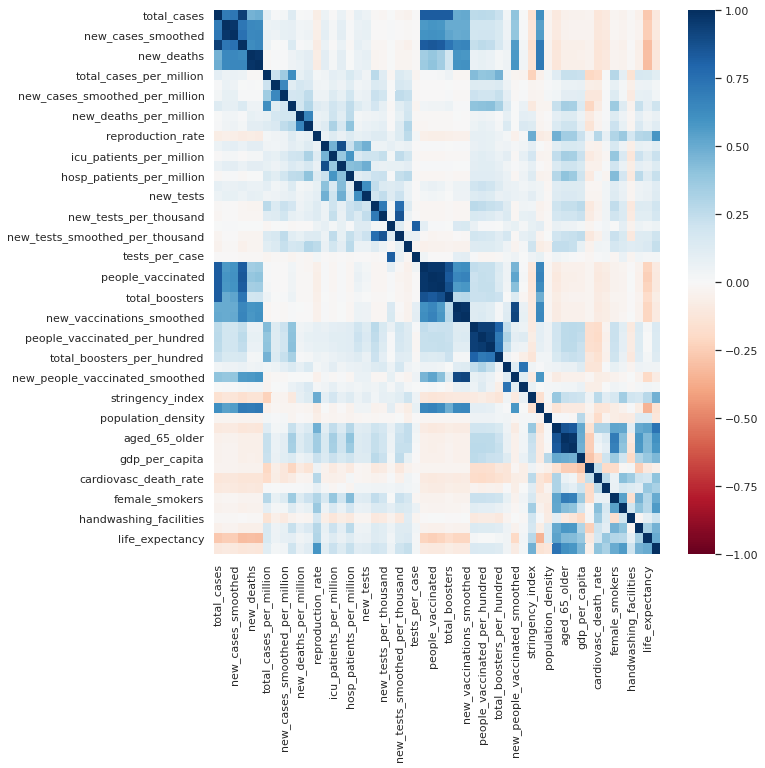

In [10]:
corr  = data.corr()

fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(corr,cmap='RdBu',vmin=-1, vmax=1, ax = ax)

In [11]:
########################## PLOTTING THE DATA ############################################
# We will stick to one month for better clarity
date_mask = (data['date'] > '2021-12-01') & (data['date'] <= '2021-12-31')   # Checking data for one month
df = data.loc[date_mask]

## Plotting new cases per region

For a given period in time, it is useful to see trends in the fluctuation of new cases. Compared to total cases, which is not that strongly related to time, new cases is a good indication of how each region is handling an influx of cases. The lineplot is useful to see and compare increases and descreases in the number of cases between different regions.

In [12]:
# Plot the increse of cases in one month over all continents
continents = list(df['continent'].value_counts().to_dict().keys())
df = df[df.continent != 0]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'New Cases over Time per Continent')

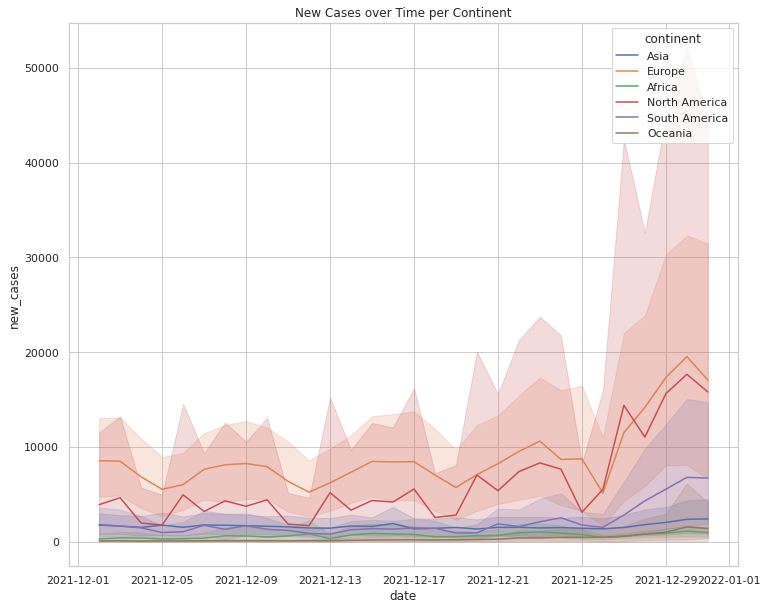

In [13]:
fig = plt.figure(figsize=(12, 10))
sns.lineplot(df['date'],df['new_cases'], hue =df["continent"])
plt.title("New Cases over Time per Continent")

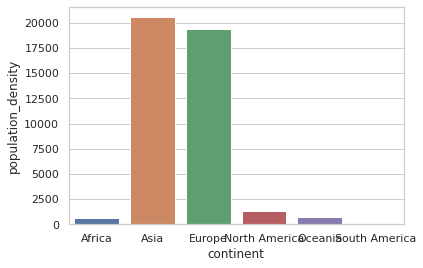

In [74]:
df2 =  data.groupby('continent', as_index = False).population_density.max()

sns.barplot(x = 'continent' , y = 'population_density', data = df2)
plt.show()

By plotting the density per continent we can also infer the reason for the difference in cases. Barplot is very useful to see the values for different instances of one variable.

In [70]:
data.groupby('continent').pop

In [50]:
df2 =  data.groupby('continent',)
df2.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
956,OWID_AFR,NaN,Africa,2020-02-13,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
957,OWID_AFR,NaN,Africa,2020-02-14,1.0,1.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
958,OWID_AFR,NaN,Africa,2020-02-15,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
959,OWID_AFR,NaN,Africa,2020-02-16,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
960,OWID_AFR,NaN,Africa,2020-02-17,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Let's get some data per country
romania = data.loc[data['location'] == 'Romania']
netherlands = data.loc[data['location'] == 'Netherlands']
france = data.loc[data['location'] == 'France']

In [15]:
country_data  = pd.concat([romania, netherlands, france])
country_data.sample(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
70262,FRA,Europe,France,2021-06-26,5810873.0,2128.0,1863.000,110978.0,12.0,32.571,...,38605.671,0.0,86.060,4.77,30.1,35.6,0.0,5.980,82.66,0.901
163838,ROU,Europe,Romania,2020-08-25,80390.0,1060.0,1168.857,3367.0,58.0,41.857,...,23313.199,5.7,370.946,9.74,22.9,37.1,0.0,6.892,76.05,0.828
70507,FRA,Europe,France,2022-02-26,22699443.0,53623.0,59854.143,138128.0,101.0,209.286,...,38605.671,0.0,86.060,4.77,30.1,35.6,0.0,5.980,82.66,0.901


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'New Cases over Time per Country')

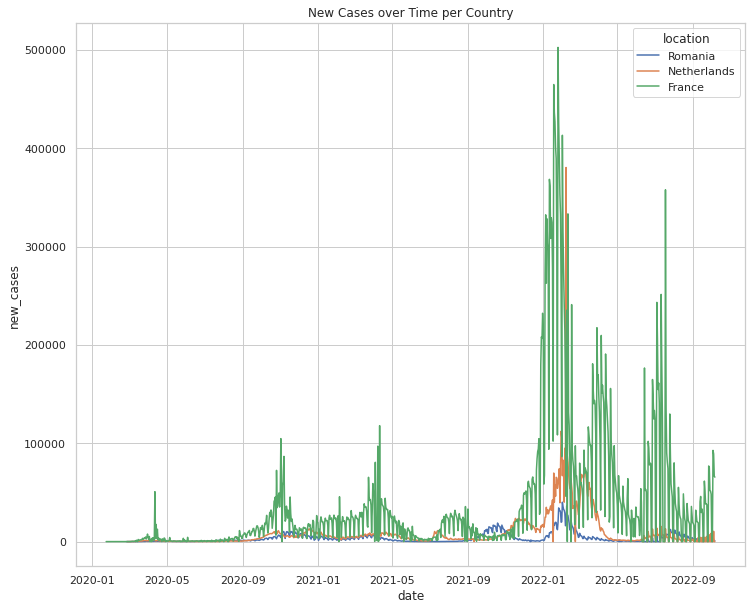

In [16]:
fig = plt.figure(figsize=(12, 10))
sns.lineplot(country_data['date'],country_data['new_cases'], hue =country_data["location"])
plt.title("New Cases over Time per Country")

We can see that France had the most cases, and highest peaks in the pandemic. We can also infer that cases were measured and aggregated in increments, as consecutive spikes oscilate a lot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


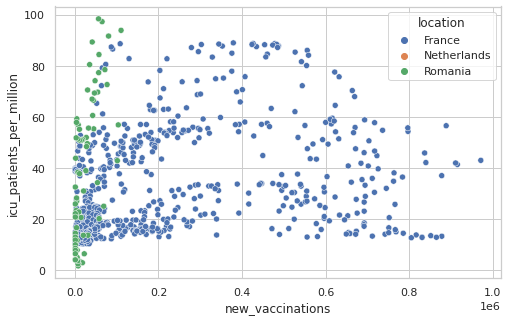

In [17]:
# Scatterplot
fig = plt.figure(figsize=(8, 5))
sns.scatterplot(country_data[country_data['new_vaccinations'] !=0]['new_vaccinations'], country_data[country_data['icu_patients_per_million'] !=0]['icu_patients_per_million'], hue = country_data['location'])

Scatterplots are useful to see relations between 2 variables and to create clusters. In this case, we want to see how new vaccinations relate to the number of icu patients. However, Romania does not even appear, and France dominates the graph. With a quick insight, we discover that this is because France's population is much higher than Netherland's or Romania's, so France's numbers skew our data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


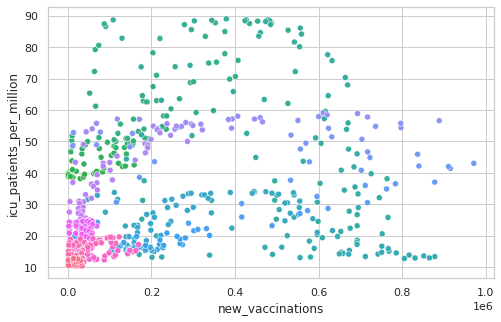

In [18]:
fig = plt.figure(figsize=(8, 5))
sns.scatterplot(france[france['new_vaccinations'] !=0]['new_vaccinations'], france[france['icu_patients_per_million'] !=0]['icu_patients_per_million'], hue = france['date'], legend = False)

With color denoting time, we can see how vaccination numbers interacted with the number of ICU patients.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


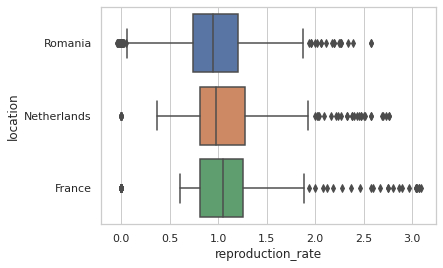

In [19]:
sns.boxplot(country_data['reproduction_rate'], country_data['location'])

With boxplot, we can see the change and overall trends, such as quartiles and the median, of a variable. In this case, we are examining the reproduction rate over the 3 countries. We can extract that Romania has some outliers, while France's reproduction rate was consistently higher than that of the 2 other countries. All countries had a time with a reproduction rate much higher than the rest of the time, as can be seen by the higher whiskers.

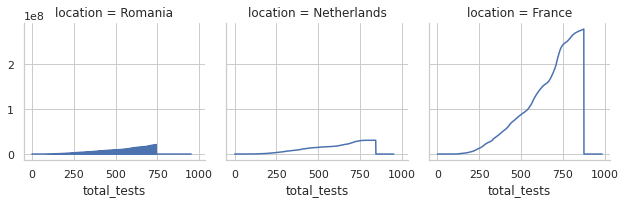

In [20]:
g = sns.FacetGrid(data = country_data, col = 'location')
plt.title('Total Tests Performed per Country')
g.map(plt.plot, 'total_tests')
plt.show()

Through this plot of total test over time, we can see how each country measured their tests. Romania does not add all the time to the total tests, so there are a lot of ups and downs in the data. Netherlands and France have a smooth curve, with a harsh drop in tests once the regulations relaxed. 

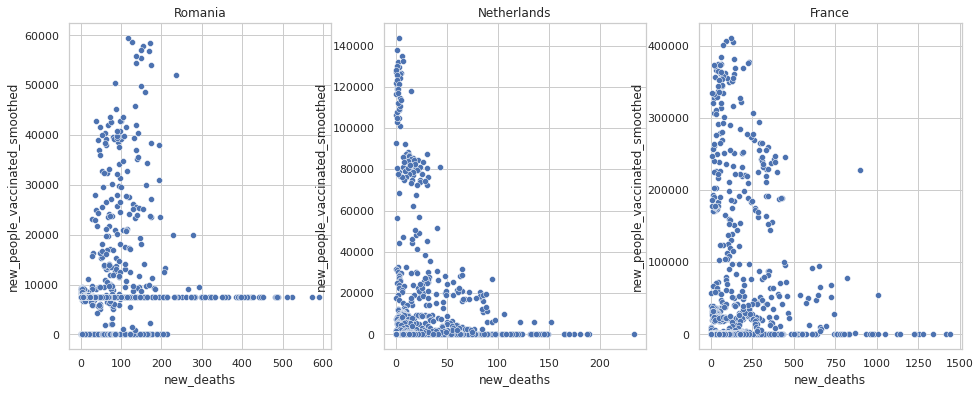

In [21]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,6))

ax1.set_title('Romania')
sns.scatterplot(x='new_deaths', y='new_people_vaccinated_smoothed', data=romania, ax=ax1)

ax2.set_title('Netherlands')
sns.scatterplot(x='new_deaths', y='new_people_vaccinated_smoothed', data=netherlands, ax=ax2)

ax3.set_title('France')
sns.scatterplot(x='new_deaths', y='new_people_vaccinated_smoothed', data=france, ax=ax3)

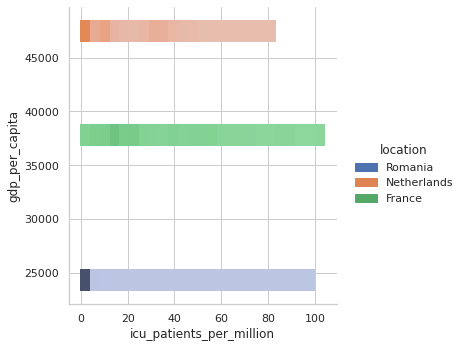

In [22]:
sns.displot(country_data, x="icu_patients_per_million", y="gdp_per_capita", hue="location")

With a distribution plot, we can variate over stable variables (GDP) to see the differences in a continuous variable (ICU patients). Romania has the lowest GDP and the biggest spread of ICU patients. Netherlands has the highest GDP and a stable number of ICU patients. 

In [25]:
import plotly.express as px
df = data[data['continent'] == 'Europe']
fig = px.scatter_3d(df, x= 'human_development_index', y= 'gdp_per_capita', z= 'life_expectancy',
               labels = ['human_development_index','gdp_per_capita', 'life_expectancy'], color='location')
fig.show()

Adding a third dimension allows us to find more patterns in the data.